In [3]:
import os
import firebase_admin
import time
from tqdm.auto import tqdm
from firebase_admin import credentials, firestore

if '.gitignore' not in os.listdir():
    os.chdir('..')

In [5]:
cred = credentials.Certificate('website-cine-e77fb4ab2924.json')
firebase_admin.initialize_app(cred)
db = firestore.client()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

### Analysing movies from offline-database (in 2022)

In [6]:
data = db.collection("offline-database").stream() 
data_per_date = dict()
for elem in data:
    elem = elem.to_dict()
    data_per_date[elem['date']] = elem

movie_stream = db.collection("movie-info").stream()
movie_info = dict()
for elem in movie_stream:
    elem = elem.to_dict()
    movie_info[elem['id']] = elem

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import os

def plot_decades(decades_played, setxticks=False, cast_int=True):
    plt.clf()
    plt.figure(figsize=(12, 6), dpi=80)
    _ = plt.gca()
    if cast_int:
        plt.bar(decades_played[:,0].astype(int), decades_played[:,1].astype(int), width=2.5)
    else:
        plt.bar(decades_played[:,0], decades_played[:,1].astype(int), width=2.5)
    
    if setxticks:
        _, _ = plt.xticks(decades_played[:,0].astype(int))
    plt.show()

def get_counters_movies_and_dates(data_per_date, movie_info):
    movies_played = Counter()
    years_played = Counter()
    decades_played = Counter()
    directors_played = Counter()
    data2022 = list()
    for date, data in data_per_date.items():
        movies_date = data["movies"]
        year_date = int(date.split("_")[0])
        if (year_date==2022):
            for mov in movies_date:
                for k, v in movies_date[mov].items():
                    for hour in v["showtimes"]:
                        year = mov.split("-")[-1]
                        if year != "None":
                            if (int(year)<=2018) and (int(year)>=1900):
                                decade = str(year)[:3]+"0"
                                director = movie_info[mov]["directors"]
                                movies_played.update([mov])
                                years_played.update([year])
                                decades_played.update([decade])
                                directors_played.update([director])
                                data2022.append([mov, date, float(hour), int(year), int(decade), director])
    return movies_played, years_played, decades_played, directors_played, data2022

movies_played, years_played, decades_played, directors_played, data2022 = \
    get_counters_movies_and_dates(data_per_date=data_per_date, movie_info=movie_info)

data2022 = pd.DataFrame (data2022, columns = ['movie', 'date', 'hour', 'year', 'decade', 'director'])
print(directors_played.most_common(25))
print(movies_played.most_common(10))

# movies_played = np.array(movies_played.most_common(100))
# plot_decades(movies_played, setxticks=False, cast_int=False)

# years_played = np.array(sorted(years_played.items()))
# plot_decades(years_played, setxticks=False)

# decades_played = np.array(sorted(decades_played.items()))
# plot_decades(decades_played, setxticks=True)
# print(data2022)

[(None, 1639), ('Pier Paolo Pasolini', 1139), ('James Cameron', 967), ('Kinuyo Tanaka', 688), ('Wong Kar-Wai', 642), ('François Truffaut', 566), ('Akira Kurosawa', 565), ('Jean Eustache', 532), ('David Lynch', 414), ('Stanley Kubrick', 393), ('Luis Buñuel', 370), ('Jean-Luc Godard', 361), ('Alan Mak, Andrew Lau', 353), ('Alfred Hitchcock', 332), ('Louis Malle', 328), ('Joseph Losey', 325), ('Bette Gordon', 313), ('Francis Ford Coppola', 268), ('Koji Morimoto, Tensai Okamura, Katsuhiro Ôtomo', 264), ('Brian De Palma', 261), ('Ettore Scola', 247), ('Gus Van Sant', 231), ('Jim Jarmusch', 230), ('Max Ophüls', 230), ('Hayao Miyazaki', 227)]
[('rex-studios-2008', 1587), ('avatar-2009', 959), ('maman-putain-1972', 532), ('rashomon-1950', 420), ('variety-1983', 313), ('memories-1995', 264), ('mamma-roma-1962', 221), ('gerry-2002', 221), ('jour-sans-fin-1993', 219), ('neige-1981', 206)]


In [82]:
df = pd.read_csv("./data/screenings.csv")
movie_info = pd.read_csv("./data/movie_info.csv")
theater_info = pd.read_csv("./data/theater_info.csv")

df["weekday"] = pd.DatetimeIndex(df["date"]).weekday
df = pd.merge(df, movie_info[["movie", "title", "directors", "duration", "language"]], on="movie")
df = pd.merge(df, theater_info[["theater", "theater_name"]], on="theater")
df["decade"] = df["year"].astype(int).astype(str).str[:3]+"0"
df

,date,showtime,movie,theater,year,weekday,title,directors,duration,language,theater_name,decade
0,2022-01-01,16.000000,les-400-coups-1959,C0074,1959.0,5,Les 400 coups,François Truffaut,6000.0,Français,Reflet Medicis,1950
1,2022-01-04,13.666667,les-400-coups-1959,C0074,1959.0,1,Les 400 coups,François Truffaut,6000.0,Français,Reflet Medicis,1950
2,2022-01-05,17.500000,les-400-coups-1959,C0074,1959.0,2,Les 400 coups,François Truffaut,6000.0,Français,Reflet Medicis,1950
3,2022-01-04,17.833333,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,NaN,Reflet Medicis,1980
4,2022-01-11,11.666667,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,NaN,Reflet Medicis,1980
...,...,...,...,...,...,...,...,...,...,...,...,...
31743,2022-10-03,20.500000,avatar-2009,C0102,2009.0,0,Avatar,James Cameron,9720.0,Français,UGC Danton,2000
31744,2022-10-04,10.083333,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,UGC Danton,2000
31745,2022-10-04,13.500000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,UGC Danton,2000
31746,2022-10-04,17.000000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,Français,UGC Danton,2000


1768


c:\Users\u.tanielian\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\u.tanielian\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


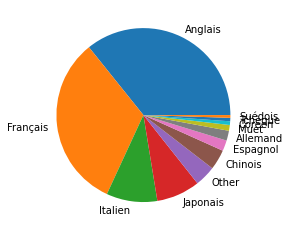

In [106]:
print(df['language'].isna().sum())

nlanguages=31748-1768

language = df[df['language'].notnull()]
language["language"] = language["language"].replace('Cantonais','Chinois')
language["language"] = language["language"].replace('Mandarin','Chinois')

language = language.groupby(['language'])
language = pd.DataFrame({
    'movie': language["movie"],
    "date" : language["date"],
    'nb_screenings':language['movie'].count(),
    'nb_days':language['date'].nunique()
}).reset_index()
language.sort_values(['nb_screenings'], ascending=[False], inplace=True)
language.loc[language['nb_screenings'] < 150, 'language'] = "Other"
language

language = language.groupby(['language'])
language = pd.DataFrame({
    'nb_screenings':language['nb_screenings'].sum(),
}).reset_index()
language.sort_values(['nb_screenings'], ascending=[False], inplace=True)
language

# language = pd.DataFrame({
#     'nb_screenings':language['movie'].count()/nlanguages,
#     'nb_days':language['date'].nunique()
# }).reset_index()
# language.sort_values(['nb_screenings'], ascending=[False], inplace=True)

plt.Figure(figsize=(15,15))
plt.pie(language['nb_screenings'], labels=language["language"])
plt.show() 

In [38]:
# screenings["movie_count"] = screenings.groupby('movie')["movie"].transform('count')
# screenings["movie_count_per_date"] = screenings.groupby('date')["movie"].transform('count')
# screenings
df

,date,showtime,movie,theater,year,weekday,title,directors,duration,theater_name
0,2022-01-01,16.000000,les-400-coups-1959,C0074,1959.0,5,Les 400 coups,François Truffaut,6000.0,Reflet Medicis
1,2022-01-04,13.666667,les-400-coups-1959,C0074,1959.0,1,Les 400 coups,François Truffaut,6000.0,Reflet Medicis
2,2022-01-05,17.500000,les-400-coups-1959,C0074,1959.0,2,Les 400 coups,François Truffaut,6000.0,Reflet Medicis
3,2022-01-04,17.833333,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,Reflet Medicis
4,2022-01-11,11.666667,louise-l-insoumise-1985,C0074,1985.0,1,Louise... l'insoumise,Charlotte Silvera,NaN,Reflet Medicis
...,...,...,...,...,...,...,...,...,...,...
31743,2022-10-03,20.500000,avatar-2009,C0102,2009.0,0,Avatar,James Cameron,9720.0,UGC Danton
31744,2022-10-04,10.083333,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,UGC Danton
31745,2022-10-04,13.500000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,UGC Danton
31746,2022-10-04,17.000000,avatar-2009,C0102,2009.0,1,Avatar,James Cameron,9720.0,UGC Danton


In [30]:
df["directors"].value_counts()

Pier Paolo Pasolini                1139
James Cameron                       967
Kinuyo Tanaka                       688
Wong Kar-Wai                        642
François Truffaut                   566
                                   ... 
Edward Dmytryk                        1
Mantas Kvedaravicius                  1
Dario Argento, George A. Romero       1
Asia Argento                          1
Barbara Hammer                        1
Name: directors, Length: 1526, dtype: int64

In [33]:
director_films = df.groupby(['directors', 'title', 'year'])
director_films = pd.DataFrame({
    'nb_screenings':director_films['movie'].count(),
    'nb_days':director_films['date'].nunique()
}).reset_index()
director_films.sort_values(['nb_screenings', 'directors'], ascending=[False, True], inplace=True)
director_films

,directors,title,year,nb_screenings,nb_days
1448,James Cameron,Avatar,2009.0,959,14
1498,Jean Eustache,La Maman et la Putain,1972.0,532,99
54,Akira Kurosawa,Rashômon,1950.0,420,46
355,Bette Gordon,Variety,1983.0,313,114
1910,"Koji Morimoto, Tensai Okamura, Katsuhiro Ôtomo",Memories,1995.0,264,46
...,...,...,...,...,...
3283,Zelimir Zilnik,Film noir,1971.0,1,1
3284,Zhi Wang,Block 70,2017.0,1,1
3285,Álex de la Iglesia,Le Jour de la bête,1995.0,1,1
3286,Álex de la Iglesia,Perdita Durango,1997.0,1,1


In [59]:
films = films[(films['year']<2018)]
films = df.groupby(['title', 'year'])
films = pd.DataFrame({
    'nb_screenings':films['movie'].count(),
    'nb_days':films['date'].nunique()
}).reset_index()

In [108]:
films_recent = films[(films['year']>=2010) & (films['year']<2016)]
films_recent.sort_values(['nb_screenings'], ascending=[False], inplace=True)
films_recent.head(30)

c:\Users\u.tanielian\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,title,year,nb_screenings,nb_days
2681,Rita et Crocodile,2015.0,97,25
3184,Ventura,2014.0,78,37
869,Il était une fois Palilula,2012.0,57,29
2458,Pacific Rim,2013.0,56,15
1732,Le Petit Nicolas,2010.0,54,6
630,Ernest et Célestine,2012.0,51,36
1943,Les Derniers jours dans le désert,2015.0,49,24
1106,L'Hiver féérique,2015.0,47,38
2253,Melancholia,2011.0,45,32
2824,Sous l'aile des anges,2014.0,40,17


In [60]:
films.sort_values(['nb_screenings'], ascending=[False], inplace=True)
films

,title,year,nb_screenings,nb_days
172,Avatar,2009.0,959,14
1351,La Maman et la Putain,1972.0,532,99
2647,Rashômon,1950.0,420,46
3178,Variety,1983.0,313,114
2254,Memories,1995.0,264,46
...,...,...,...,...
934,Janis et John,2002.0,1,1
936,Jaurès,2012.0,1,1
937,Jawbreaker,1999.0,1,1
939,Je ne me souviens de rien,2017.0,1,1


In [61]:
films.sort_values(['nb_days'], ascending=[False], inplace=True)
films

,title,year,nb_screenings,nb_days
3178,Variety,1983.0,313,114
882,In the Mood for Love,2000.0,130,114
1351,La Maman et la Putain,1972.0,532,99
2339,Mulholland Drive,2001.0,112,84
11,2001 : l'odyssée de l'espace,1968.0,93,83
...,...,...,...,...
3220,Vénus et Fleur,2003.0,1,1
3221,Vérité et mensonges,1973.0,1,1
44,A la poursuite d'Octobre rouge,1990.0,1,1
76,"Alain Cavalier, 7 chapitres, 5 jours 2 pieces-...",1995.0,1,1


In [62]:
decades = df.groupby(['decade'])
decades = pd.DataFrame({
    'nb_screenings':decades['movie'].count(),
    'nb_days':decades['date'].nunique()
}).reset_index()
decades = decades[decades['decade']>"1899"]
decades.sort_values(['decade'], ascending=[True], inplace=True)
decades

,decade,nb_screenings,nb_days
2,1900,10,5
3,1910,60,54
4,1920,432,201
5,1930,745,234
6,1940,1238,288
7,1950,3090,321
8,1960,5475,345
9,1970,4834,341
10,1980,4106,341
11,1990,3712,337


<Figure size 432x288 with 0 Axes>

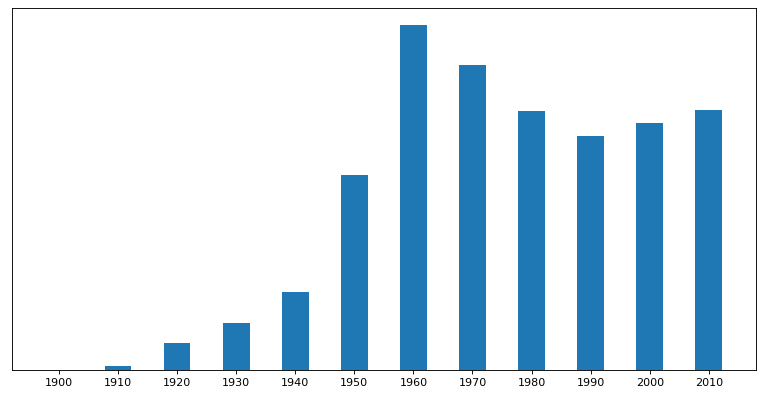

In [66]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_decades(decades_played, setxticks=False, cast_int=True):
    plt.clf()
    plt.figure(figsize=(12, 6), dpi=80)
    _ = plt.gca()
    if cast_int:
        plt.bar(decades_played[:,0].astype(int), decades_played[:,1].astype(int), width=4.5)
    else:
        plt.bar(decades_played[:,0], decades_played[:,1].astype(int), width=2.5)
    
    if setxticks:
        _, _ = plt.xticks(decades_played[:,0].astype(int))
        plt.yticks([], [])
    plt.show()

plot_decades(decades.to_numpy(), setxticks=True, cast_int=True)

In [12]:
#Number of different movies & directors
movie_set = set(list(data2022["movie"].to_numpy()))
director_set = set(list(data2022["director"].to_numpy()))
print(len(data2022), len(movie_set), len(director_set))

33333 3299 1526


In [1]:
### Get one movie per director
movie_per_director = dict()
data_movie_director = data2022[["movie", "director"]]
for index, row in data_movie_director.iterrows():
    dir, mov = row["director"], row["movie"]
    if dir in movie_per_director:
        if mov not in movie_per_director[dir]:
            movie_per_director[dir].append(mov)
    else:
        movie_per_director[dir] = [mov]

for k in sorted(movie_per_director, key=lambda k: len(movie_per_director[k]), reverse=True):
    print(k, len(movie_per_director[k]), movie_per_director[k])


NameError: name 'data2022' is not defined

In [57]:
###Screening on the hours...
data2022_early = data2022.loc[data2022['hour'] < 16]
data2022_afternoon = data2022.loc[(data2022['hour'] >= 16) & (data2022['hour'] <= 20)]
data2022_late = data2022.loc[data2022['hour'] > 20]
print(len(data2022_early)/len(data2022), len(data2022_afternoon)/len(data2022), len(data2022_late)/len(data2022))
counter_movies = Counter(list(data2022["movie"].to_numpy()))
print(counter_movies.most_common(20))
print("####")
print(Counter(list(data2022_early["movie"].to_numpy())).most_common(10))
print(Counter(list(data2022_afternoon["movie"].to_numpy())).most_common(10))
counter_late = Counter(list(data2022_late["movie"].to_numpy()))
for elem in counter_late.most_common(10):
    print(elem, elem[1]/counter_movies[elem[0]])

0.42759427594275945 0.3970239702397024 0.17538175381753818
[('rex-studios-2008', 1587), ('avatar-2009', 959), ('maman-putain-1972', 532), ('rashomon-1950', 420), ('variety-1983', 313), ('memories-1995', 264), ('mamma-roma-1962', 221), ('gerry-2002', 221), ('jour-sans-fin-1993', 219), ('neige-1981', 206), ('lettre-inconnue-1948', 200), ('tears-go-ainsi-vont-larmes-1988', 193), ('salo-120-journees-sodome-1975', 188), ('accattone-1961', 184), ('les-petites-marguerites-1966', 172), ('nos-annees-sauvages-1990', 169), ('the-truman-show-1998', 167), ('infernal-affairs-2002', 160), ('lost-highway-1997', 150), ('edward-mains-argent-1990', 148)]
####
[('rex-studios-2008', 969), ('avatar-2009', 406), ('maman-putain-1972', 263), ('rashomon-1950', 177), ('mamma-roma-1962', 124), ('memories-1995', 108), ('tears-go-ainsi-vont-larmes-1988', 99), ('variety-1983', 92), ('lettre-inconnue-1948', 89), ('accattone-1961', 86)]
[('rex-studios-2008', 618), ('avatar-2009', 284), ('maman-putain-1972', 240), ('ra